# CS448 - Lab 4: 3D Audio


In this lab we will learn how to create 3D sounds for headphone playback. We will make use of simple filters and HRTFs to create static and moving sources. Use the three sounds fly.wav, helicopter.wav, and crumble.wav in the lab archive as sources for the 3D recording that you will create.

## Part 1: Static sources using ITD/ILD cues

Assume the following source locations: 

- Straight ahead

- 45 degrees to the left

- 80 degrees to the right

- 160 degrees to the left

For each location find the source’s delay between the two ears (assume a source distance of 2 meters), and design two filters that will simulate that ITD and ILD features (feel free to round the IDT delays to an integer sample size). Assume that when sounds come from the side of the head the attenuation at the contralateral ear is by a factor of 0.7. From sounds coming medial plane (between the ears) there will be no attenuation due to the head. For positions moving from the medial plane towards the sides you can interpolate between no attenuation and a factor of 0.7. Design and plot the filters that correspond to the locations shown above and use them to make 3D sounds with the following sounds:

- Crumbling paper: [https://drive.google.com/uc?export=download&id=1bsZArYwMftsuCLdMknRomz4kAJWT-Uhv ]

- Fly: [https://drive.google.com/uc?export=download&id=1bswUsI28yJOUQuNLvNxq3pu9qj0bb8ne ]

- Helicopter: [https://drive.google.com/uc?export=download&id=1c8YhNNLmaO7CA2dJNCkBsB9MY0HjHDRL ]

Listen to the result through headphones and verify that they sound somewhat localized (it won’t sound perfect, but it should be believable).  There is no need to render all three sounds, since the notebook will become very large and hard to upload.  At submission time just render one sound, but make sure that you listen to all three and that they sound good.

In [2]:
# Load a remote WAVE file given its URL, and return the sample rate and waveform
def wavreadurl( url):
    import urllib.request, io, scipy.io.wavfile
    f = urllib.request.urlopen( urllib.request.Request( url))
    sr,s = scipy.io.wavfile.read( io.BytesIO( f.read()))
    return sr, s.astype( 'float32')/32768

# Make a sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display( HTML( 
    '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
    '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
    ))

# Import graphics
from matplotlib.pylab import figure, text, xlabel, xticks, yticks, title, stem, gca, subplot, plot, axis, ylim, tight_layout, bar, legend, ylabel
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# sr,s = wavreadurl( 'https://drive.google.com/uc?export=download&id=1bsZArYwMftsuCLdMknRomz4kAJWT-Uhv')

from scipy.signal import convolve
from numpy import array, sqrt, zeros, convolve, array, sin, cos, pi, vstack, arange

(2, 148864)


(2, 148873)


(2, 148877)


(2, 148868)


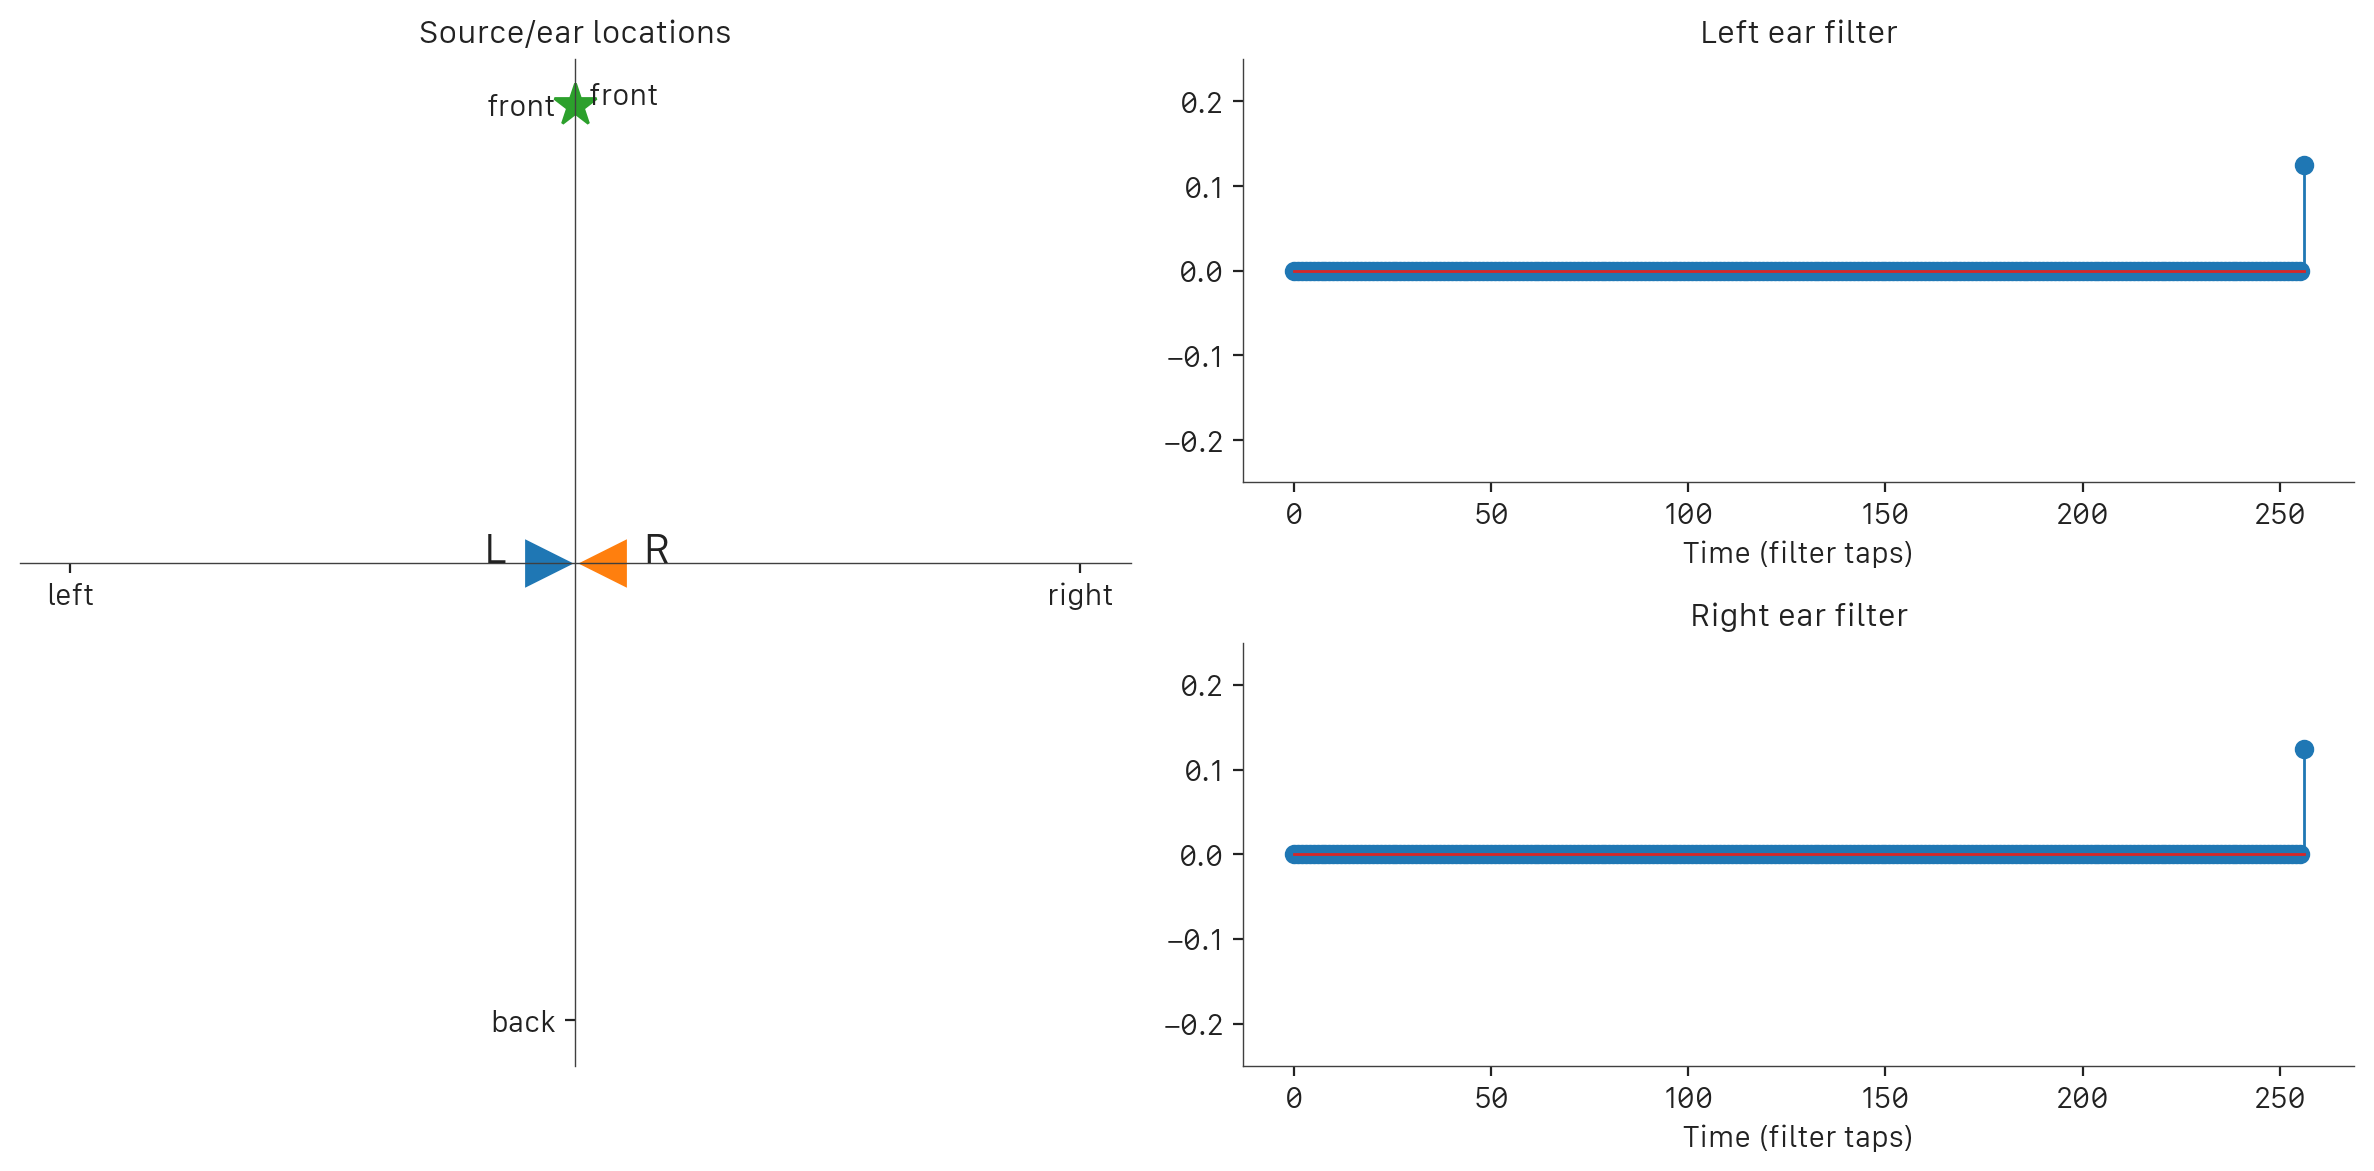

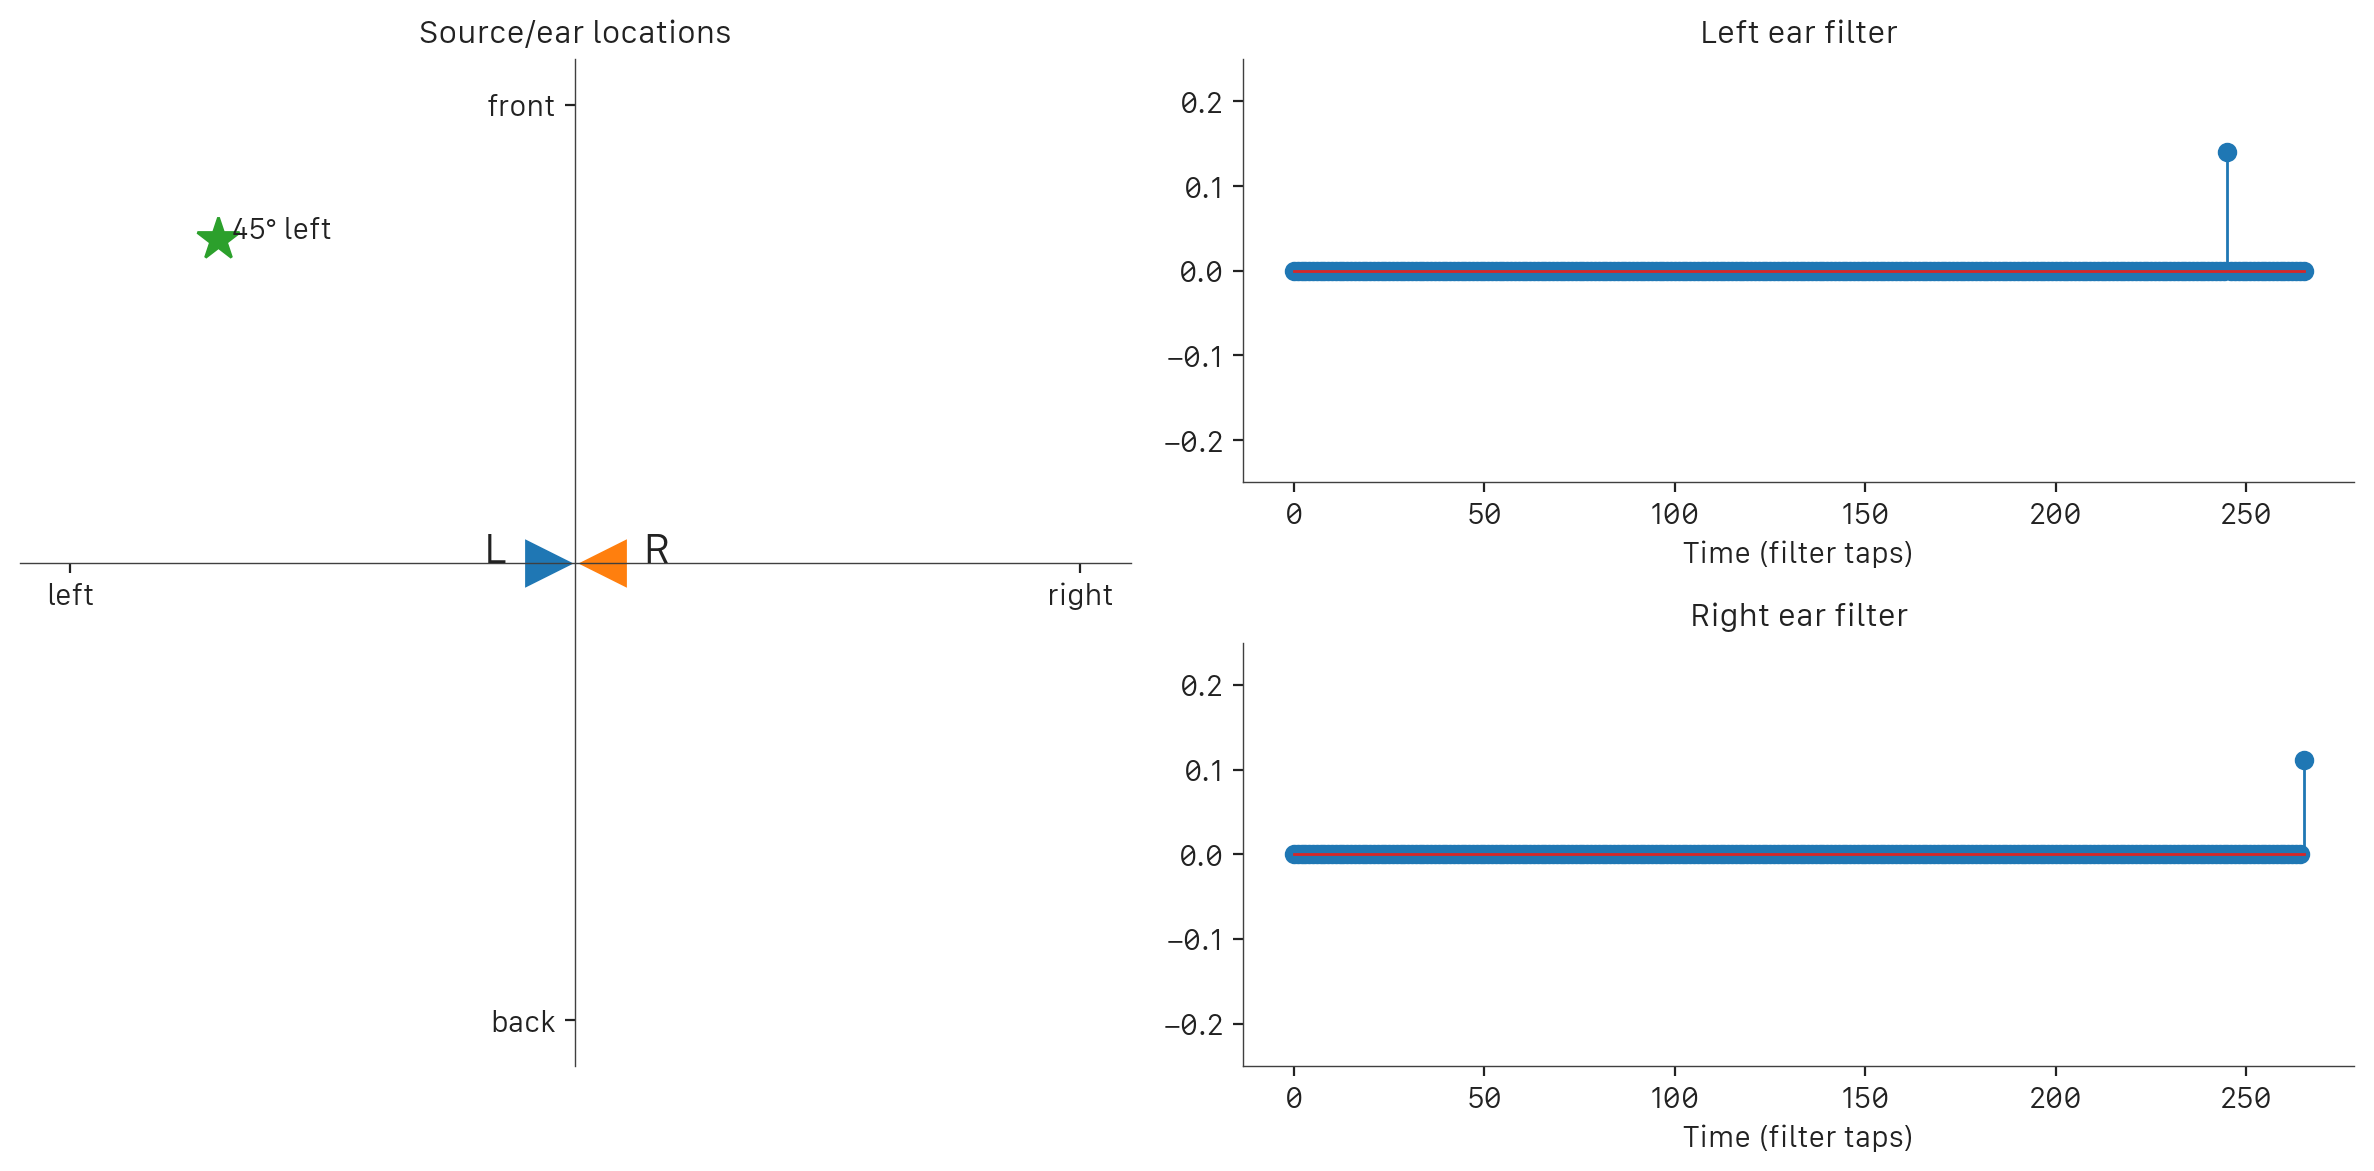

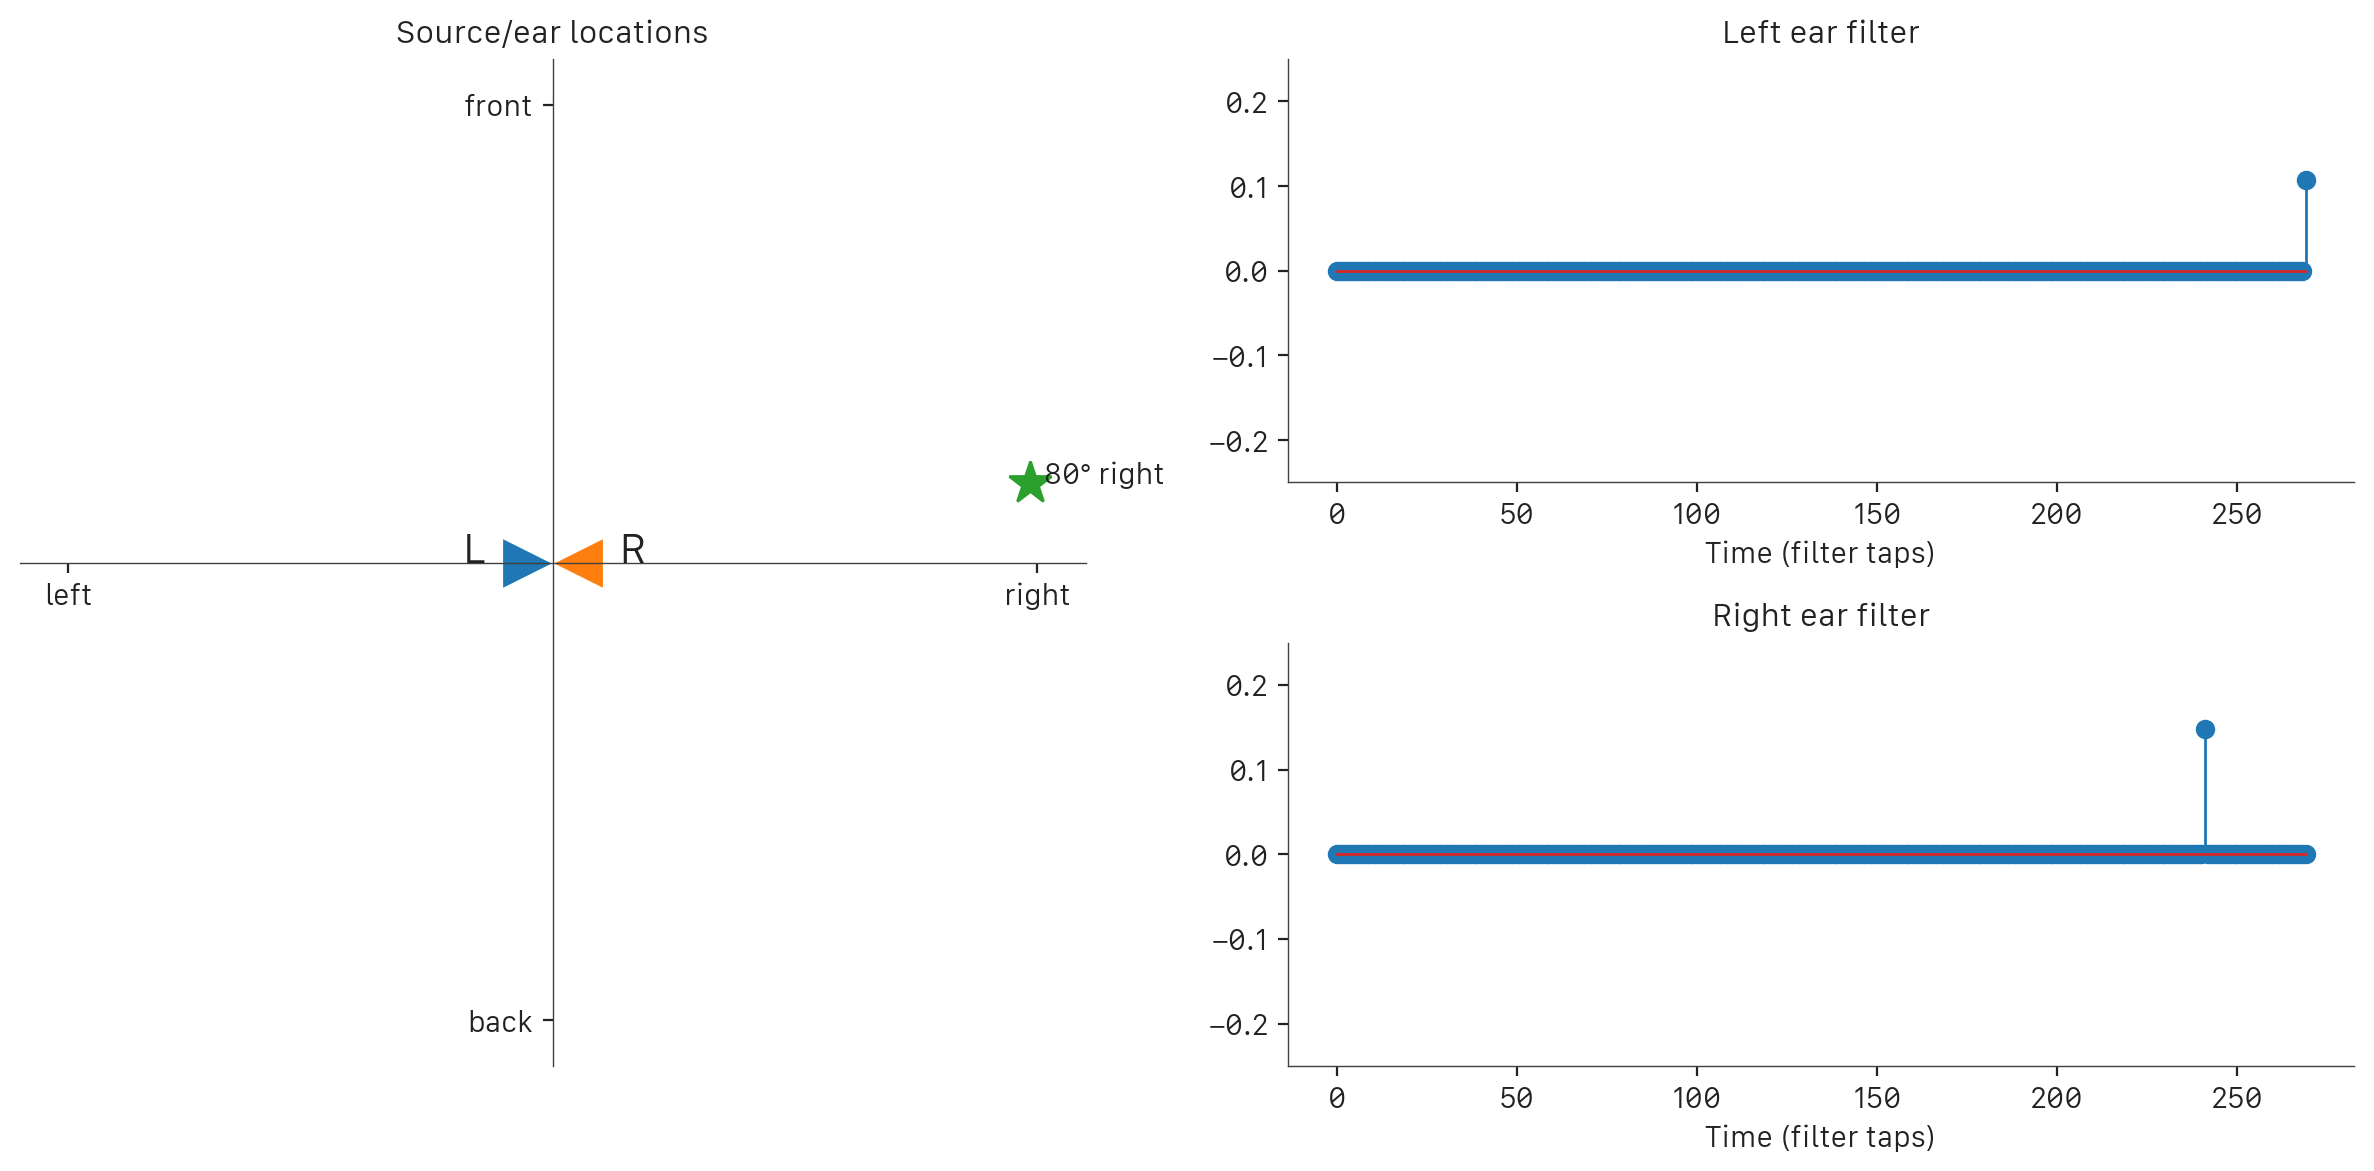

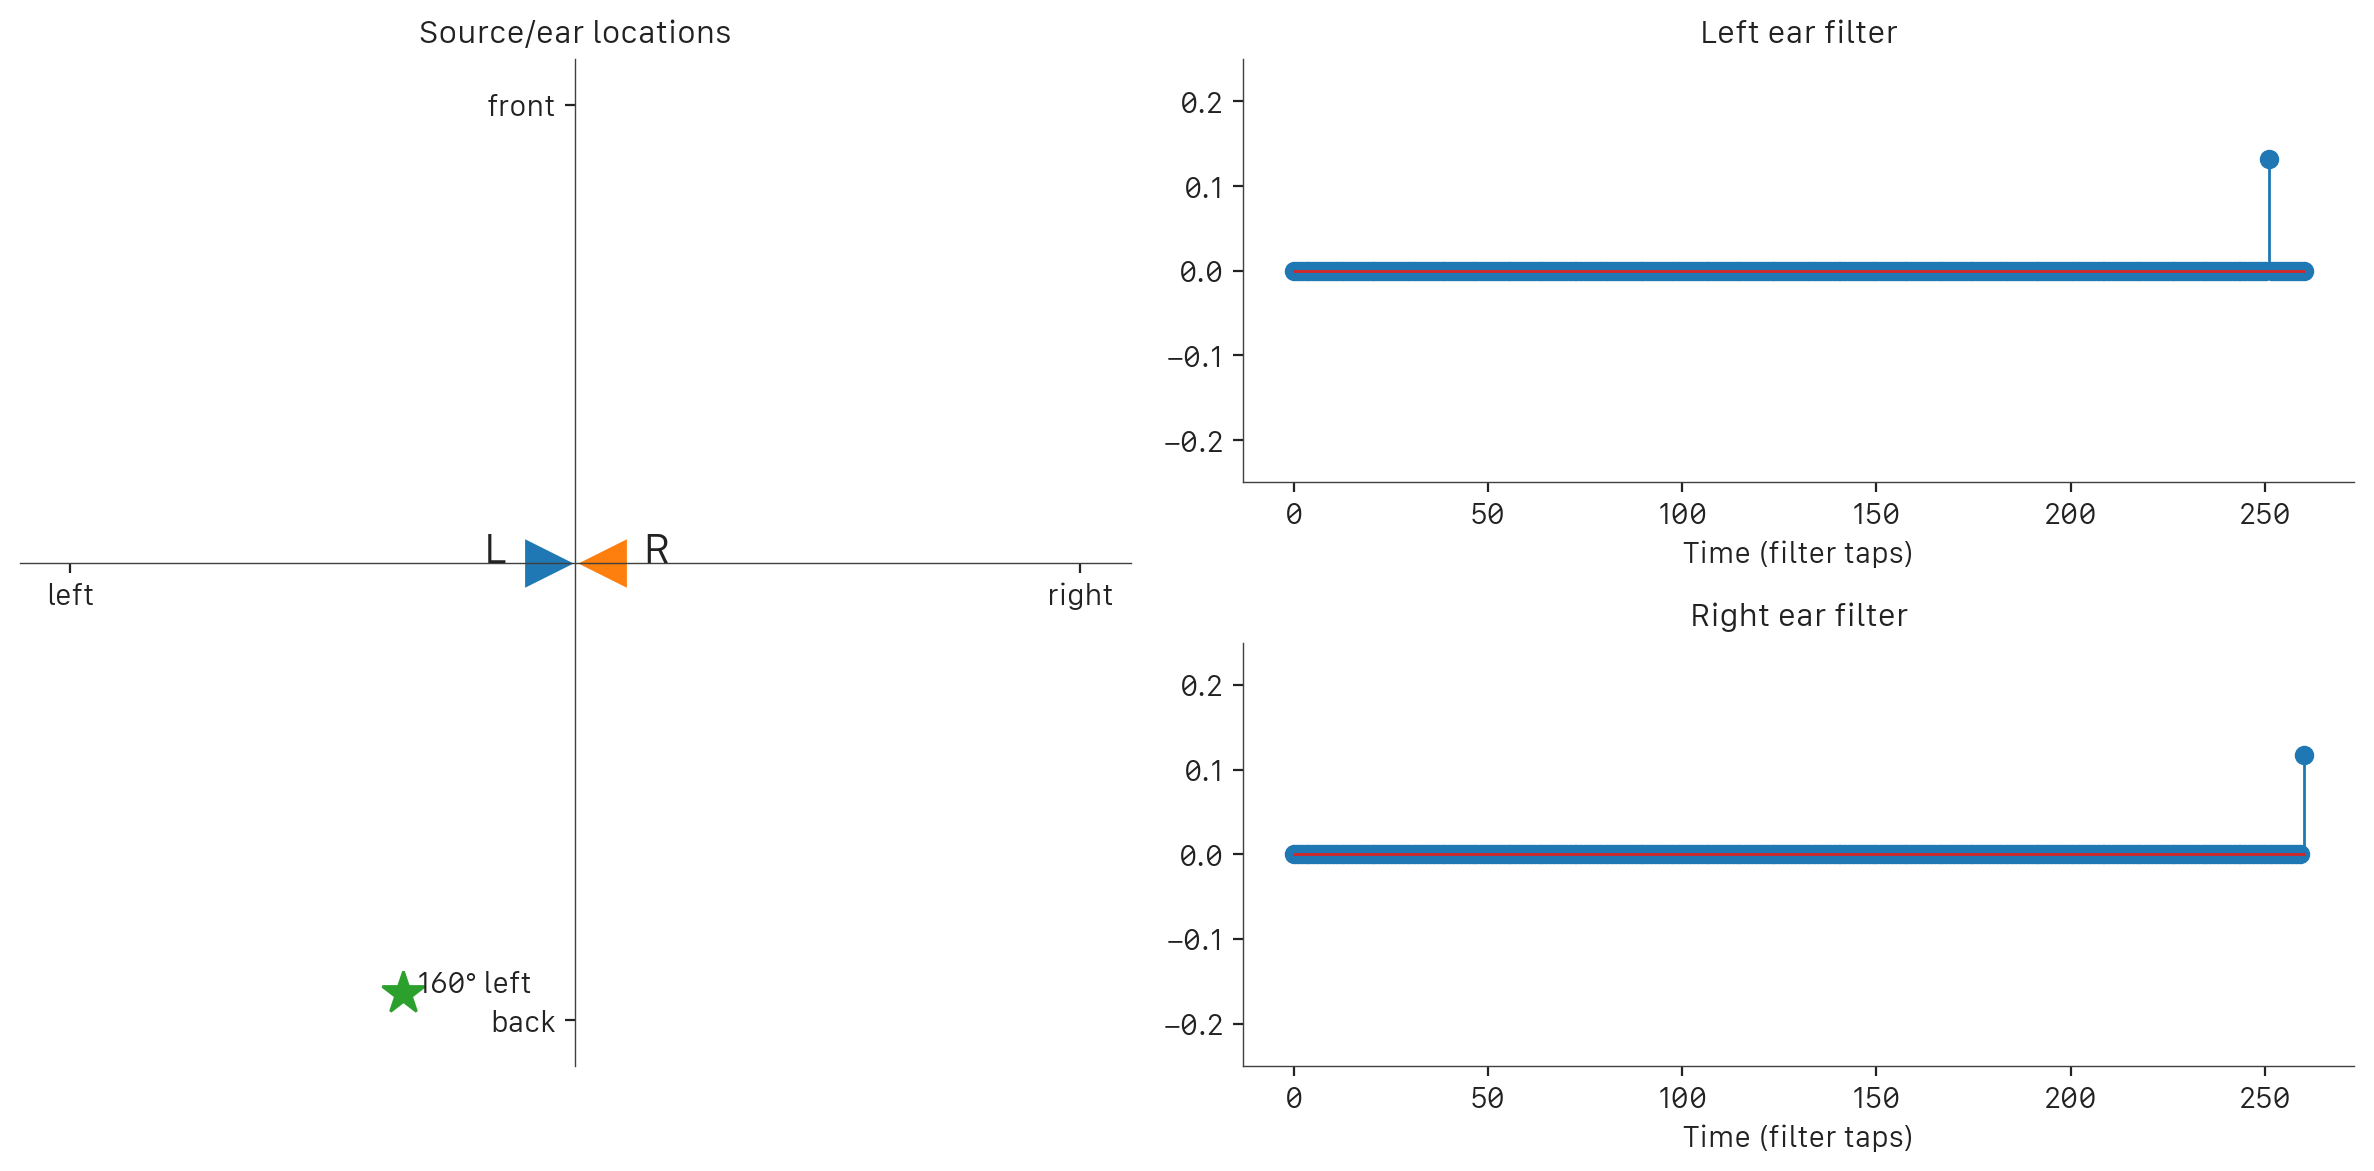

In [41]:
# Locations to create
loc = [[0,0],[-45,0],[80,0],[-160,0]]
lab = ['front', '45° left', '80° right', '160° left']

# Ear positions (meters)
mp = [[-.11, 0], [.11, 0]]

# For each location
for i in range( len( loc)):
    figure()
    # Get delays
    sp = 2*array( [sin( pi*loc[i][0]/180), cos( pi*loc[i][0]/180)])
    d1 = sr * sqrt( sum( (sp-mp[0])**2)) / 345
    d2 = sr * sqrt( sum( (sp-mp[1])**2)) / 345

    # Remove common delay component (it doesn't matter, just makes the filters smaller)
    # md = min( d1, d2)
    # d1 = d1 - md
    # d2 = d2 - md

    # Make the filter delays
    f1 = zeros( int( max( d1, d2)+1))
    f2 = zeros( int( max( d1, d2)+1))

    # Make the filter attenuations using a cubed distance loss
    f1[int(d1)] = sqrt( sum( (sp-mp[0])**2))**-3
    f2[int(d2)] = sqrt( sum( (sp-mp[1])**2))**-3

    # Convolve and play
    y = vstack( (convolve( s, f1),convolve( s, f2)))
    print( y.shape)
    sound( y[:,:sr], sr)
    
    # Show me
    subplot( 1, 2, 1)
    plot( mp[0][0], mp[0][1], '>', ms=16)
    plot( mp[1][0], mp[1][1], '<', ms=16)
    text( mp[0][0], mp[0][1], 'L    ', ha='right', size=16)
    text( mp[1][0], mp[1][1], '    R', ha='left', size=16)
    plot( sp[0], sp[1], '*', ms=16)
    text( sp[0], sp[1], '  ' + lab[i])
    title( 'Source/ear locations')
    axis( [-2.2,2.2,-2.2,2.2])
    gca().spines['left'].set_position('center')
    gca().spines['bottom'].set_position('center')
    gca().spines['right'].set_color('none')
    gca().spines['top'].set_color('none')
    xticks( [-2,2], ['left', 'right'])
    yticks( [-2,2], ['back', 'front'])

    subplot( 2, 2, 2)
    stem( f1)
    ylim( [-.25,.25])
    xlabel( 'Time (filter taps)')
    title( 'Left ear filter')
    subplot( 2, 2, 4)
    stem( f2)
    ylim( [-.25,.25])
    xlabel( 'Time (filter taps)')
    title( 'Right ear filter')
    tight_layout()


## Part 2. Static sources using HRTFs

Download the HTTF archive from [https://drive.google.com/uc?export=download&id=1vFzSo-zlNFI-q2T9yvRRmOeZ-elZ8lW3 ]. In that directory you will also find code for the function load_hrtf which returns the left and right HRTF filters given as input a source’s azimuth and elevation. These filters will be much better than the ITD/ILD filters for localizing sounds.

Apply the HRTFs on the given sources and create 3D sounds that correspond to the locations given above. For each source, you will beed to convolve it with the left and right HRTF of the desired position and generate two sounds, one for each channel. Verify that they sound correct using headphones; are they better than before? What differences do you observe? When you use these make sure that the sample rates of the HRTFs and the sounds you convolve them with match.  The HRTFs are sampled at 44.1kHz.

Once again, just render one example before submission (the same as before so that we can compare).

In [42]:
def load_hrtf( ad, ed):
    # Return the HRTFs for a given azimuth and elevation
    #  function h,a,e = load_hrtf( ad, ed)
    #
    # Inputs:
    #   ad  is the azimuth to use in degrees (0 is front)
    #   ed  is the elevation to use in degrees (0 is level with ears)
    #
    # Output:
    #   l,r two 128pt arrays, first is left ear HRTF, second is right ear HRTF
    from numpy import remainder, fromfile

    # Path where the HRTFs are
    p = 'hrtf/compact/'

    # Get nearest available elevation
    e = max( -40, min( 90, 10*(ed//10)))

    # Get nearest available azimuth
    ad = remainder( ad, 360)
    if ad > 180:
        ad = ad-360
    if ad < 0:
        a = abs( ad)
        fl = 1
    else:
        a = ad
        fl = 0
    a = max( 0, min( 180, 5*(a//5)))

    # Load appropriate response
    h = fromfile( '%s/elev%d/H%de%.3da.dat' % (p, e, e, a), dtype='>i2').astype( 'double')/32768
    if fl:
        return h[1::2],h[::2]
    else:
        return h[::2],h[1::2]

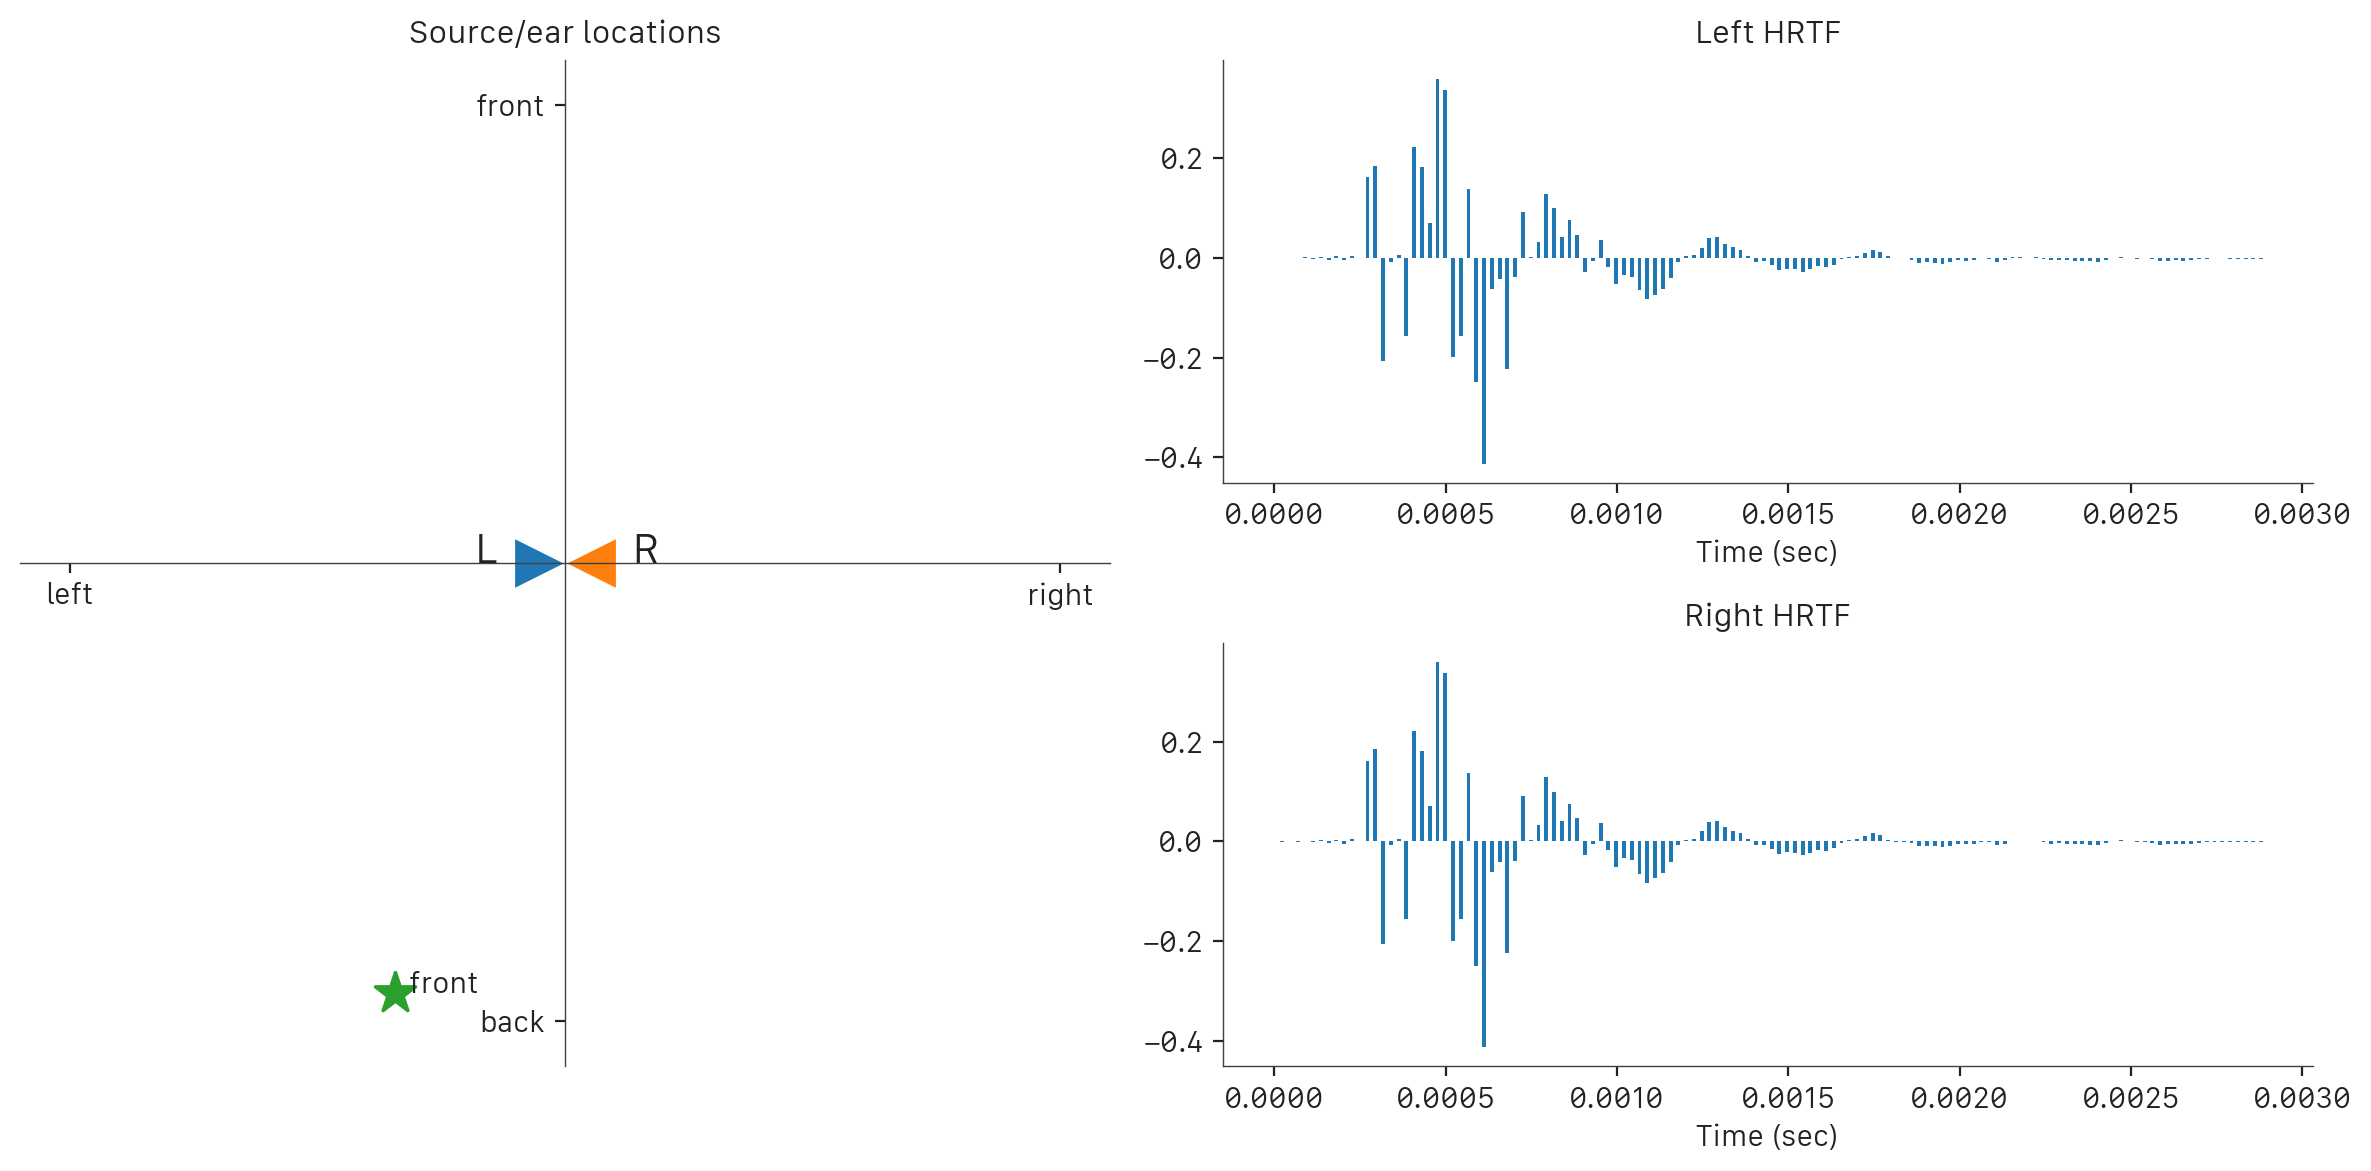

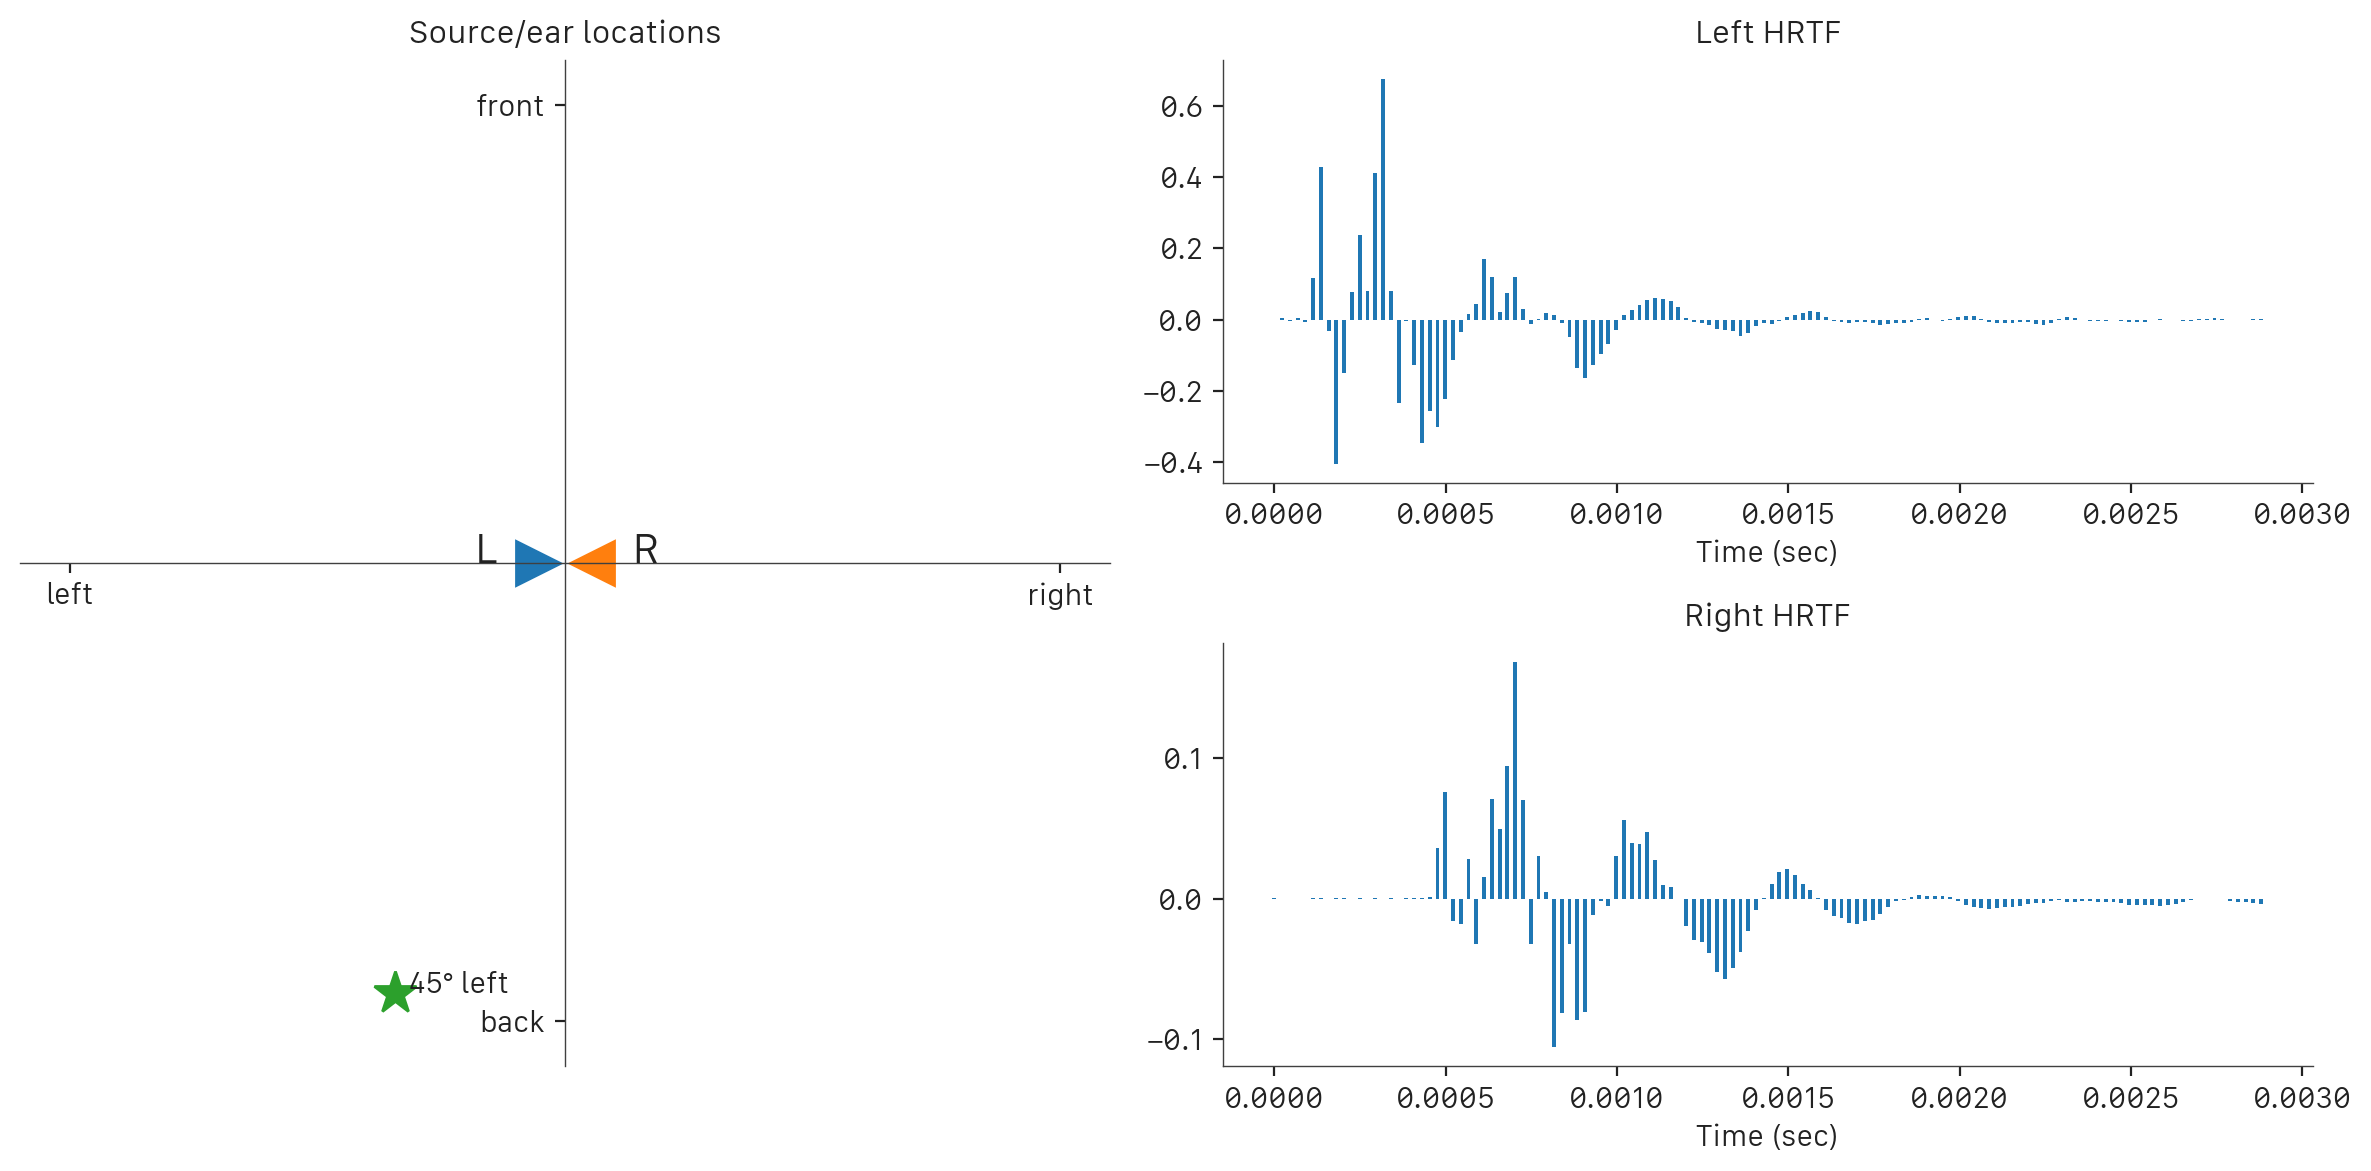

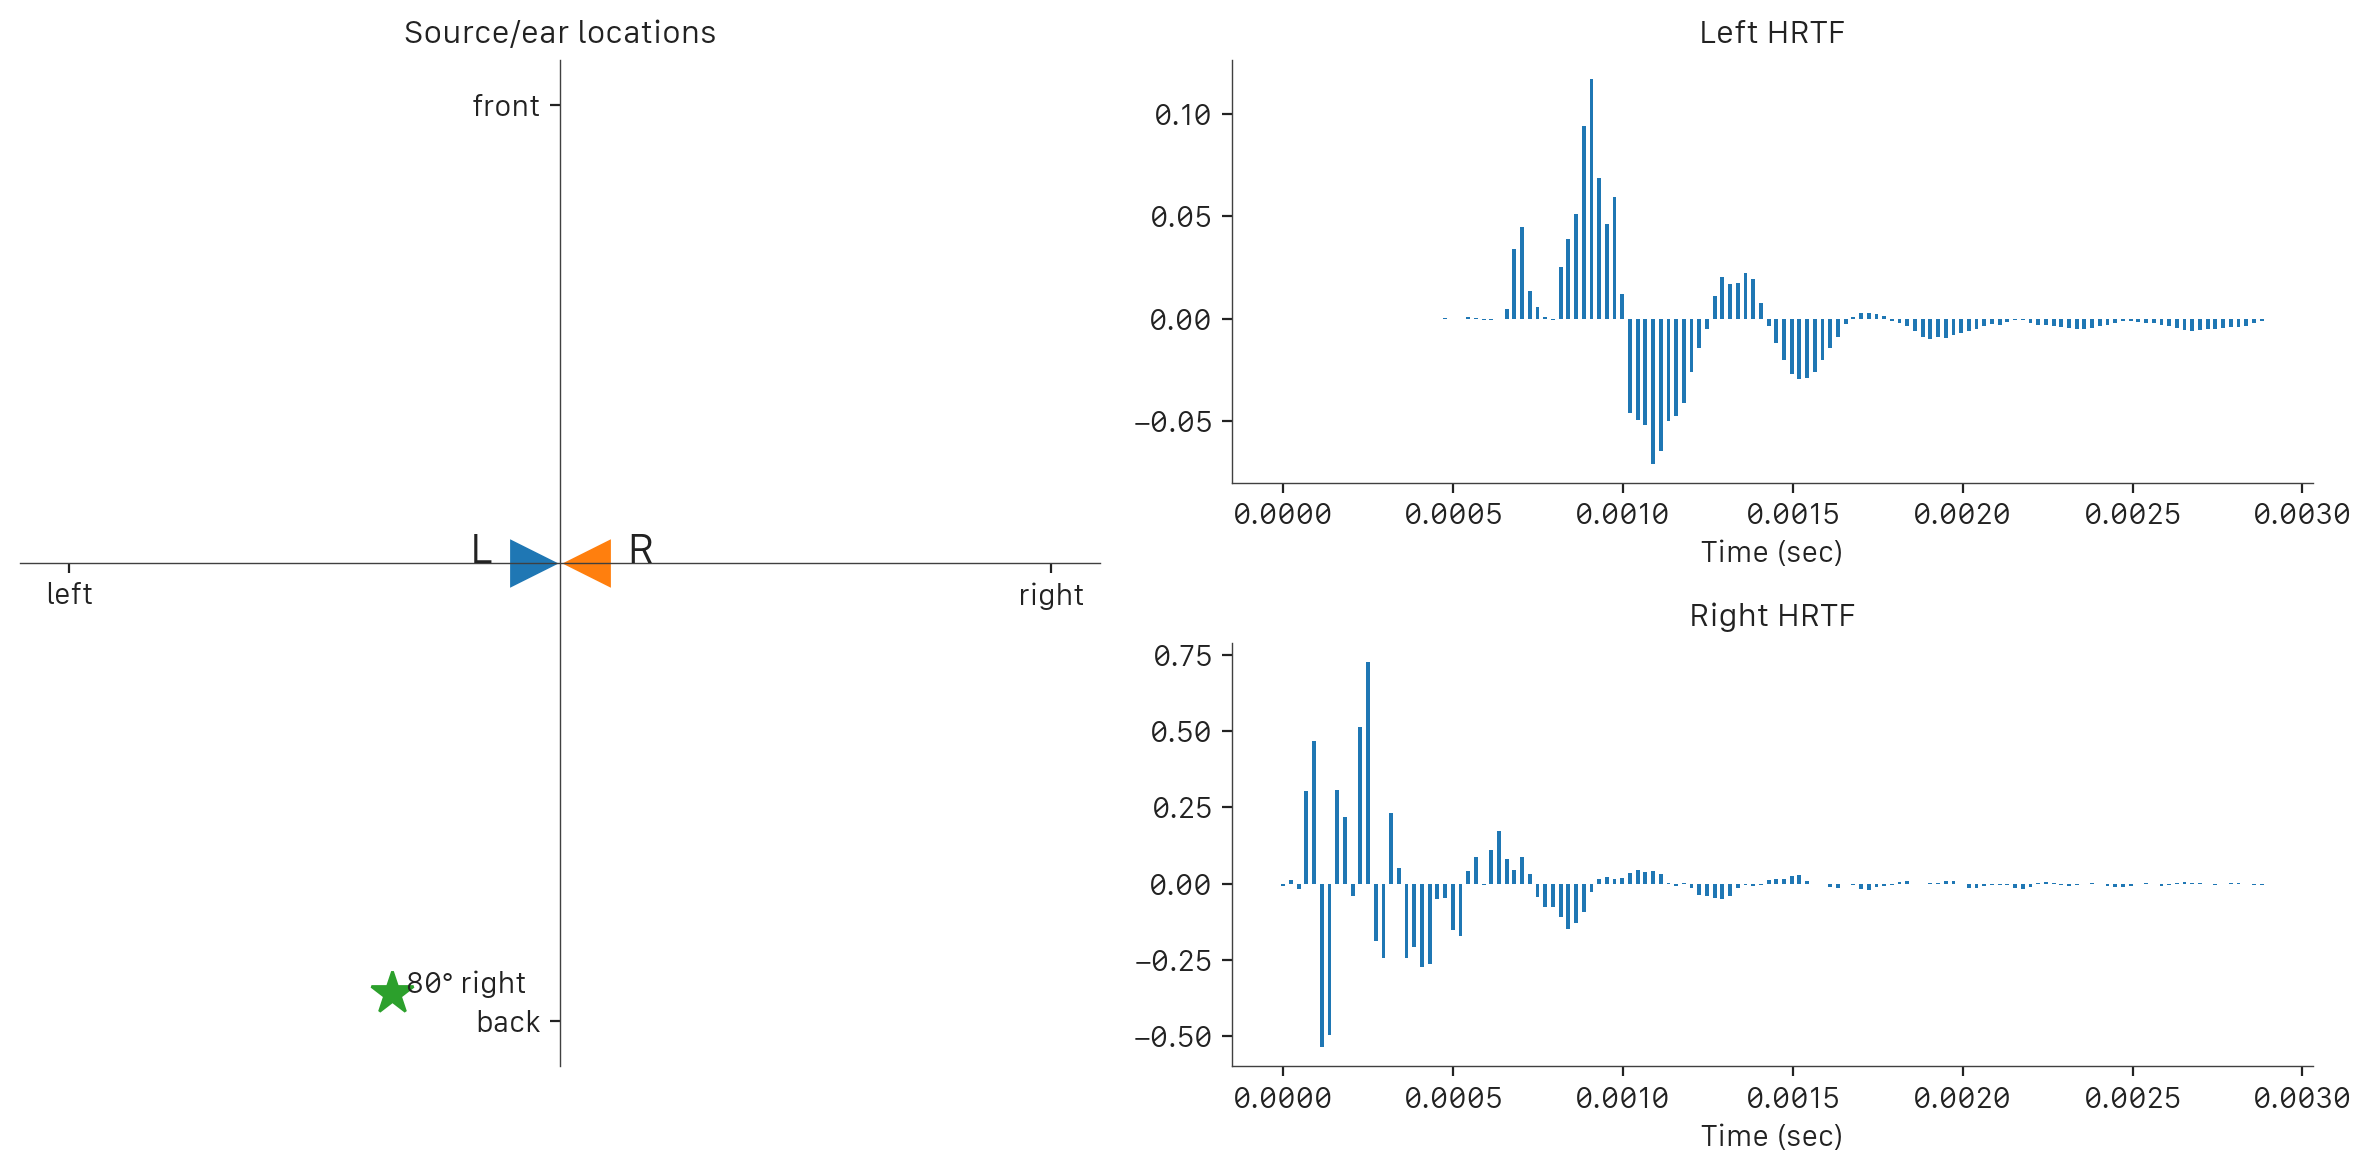

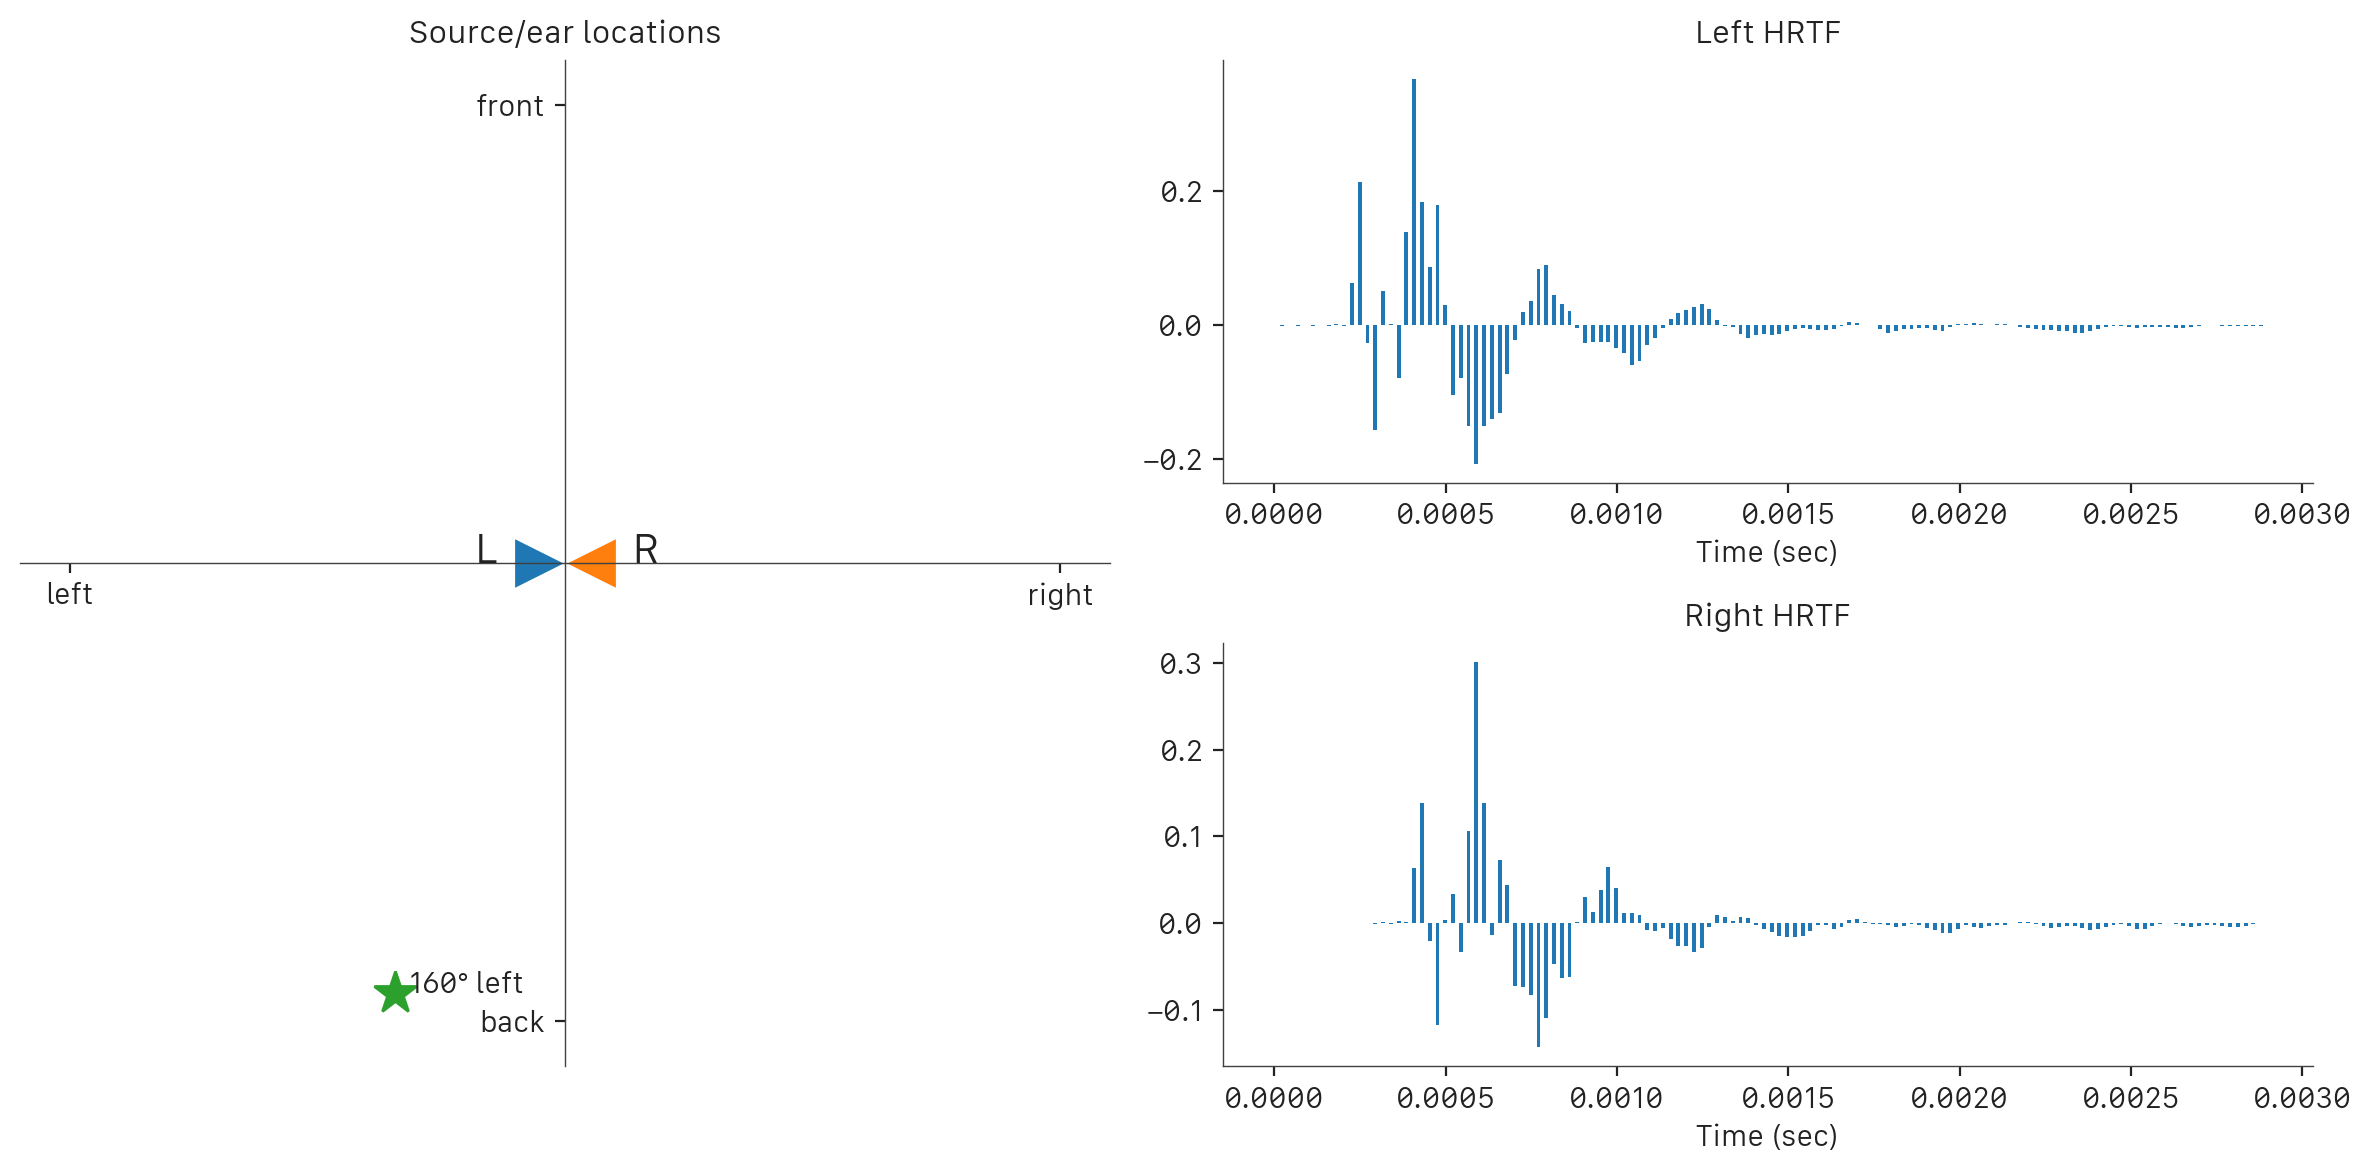

In [44]:
# For each location
for i in range( len( loc)):
    # Get HRTFs
    f1,f2 = load_hrtf( loc[i][0], loc[i][1])

    # Convolve with them
    y = vstack( (convolve( s, f1),convolve( s, f2)))
    sound( y[:,:sr], sr)
 
    # Show me
    figure()# figsize=(8,3))
    subplot( 1, 2, 1)
    plot( mp[0][0], mp[0][1], '>', ms=16)
    plot( mp[1][0], mp[1][1], '<', ms=16)
    text( mp[0][0], mp[0][1], 'L    ', ha='right', size=16)
    text( mp[1][0], mp[1][1], '    R', ha='left', size=16)
    plot( sp[0], sp[1], '*', ms=16)
    text( sp[0], sp[1], '  ' + lab[i])
    title( 'Source/ear locations')
    axis( [-2.2,2.2,-2.2,2.2])
    gca().spines['left'].set_position('center')
    gca().spines['bottom'].set_position('center')
    gca().spines['right'].set_color('none')
    gca().spines['top'].set_color('none')
    xticks( [-2,2], ['left', 'right'])
    yticks( [-2,2], ['back', 'front'])

    subplot( 2, 2, 2)
    bar( arange( len( f1))/sr, f1, width=.5/sr)
    xlabel( 'Time (sec)')
    title( 'Left HRTF')
    subplot( 2, 2, 4)
    bar( arange( len( f2))/sr, f2, width=.5/sr)
    xlabel( 'Time (sec)')
    title( 'Right HRTF')
    tight_layout()

## Part 3. Dynamic Sources with HRTFs

In this part you will need to make a moving sound source. In order to do so we will make use of a fast convolution routine based on your STFT code from lab 1 (ha, you thought you were done with that!). In order to perform fast convolution we can perform an STFT of the sound to use, multiply each time frame of this transform with the DFT of the filter that we want  to impose and then use overlap add to transform back to the time domain.

Start by taking each sound from above, and apply your STFT on it. Make sure that the size of the transform is the same as the HRTF’s filter length. The hop size should be the same as the DFT size and you will need to zero pad by as much as the DFT size in order to facilitate the tail of the convolution. Do not use an analysis/synthesis window.

Once you compute this STFT, go through its every time frame and element-wise multiply it with the desired HRTF filter to generate the STFT of the left and right sounds. Figure out which HRTF angle to multiply each frame with so that by the end of the sound you will have made it go around your head.

Once you perform these operations you will have generated two STFT matrices, one for the left channel and one for the right. Use your inverse STFT routine and play the stereo sound through your headphones. You should hear a convincing rendering of the original sounds circling around your head.

Submit only one of the sounds, but make sure you try it on all and that it sounds ok.

In [45]:
# Moving sources
from numpy.fft import rfft, irfft
from numpy import reshape, copy, linspace

def dynamic_hrtf( s, a):    
    # Get rough STFT
    f = rfft( reshape( s[:128*(len(s)//128)], (128,-1), 'F'), 256, axis=0)

    # Convolve with everchanging HRTFs
    fl = copy( f)
    fr = copy( f)
    for i in range( len( a)):
        l,r = load_hrtf( a[i], 0)
        fl[:,i] *= rfft( l, 256)
        fr[:,i] *= rfft( r, 256)

    # Overlap add
    z = zeros( (2,128*(len(s)//128)+256))
    for i in range( fl.shape[1]):
        z[0,(i*128):(i*128+256)] += irfft( fl[:,i])
        z[1,(i*128):(i*128+256)] += irfft( fr[:,i])

    return z

# Make it go around the head
z = dynamic_hrtf( s, linspace( 0, 360, len(s)//128))

# Play the result
sound( z, sr)

## Part 4. Extra credit (required for 4-hour credit registrants)

Use the file in [https://drive.google.com/uc?export=download&id=1bxQkXcGa57S3G7IRWu9urS-jCPdf5Pif ] to make a short story. This is a 7-channel file of a scene from a really bad B-movie. Each channel contains a different sound. If you play that sound you probably won’t hear most of the content since you won’t have a 7 speaker setup, import it in a multi-channel editor such as Audacity and you will get a sense of what’s in there. Since it sounds so boring you need to add some reverb and 3D-locate the sounds so that it sounds more exciting. Try to make it sound better using what we have done so far. Keep in mind that you can add different amounts of reverb for each sound, and you can dynamically 3D place them as well.

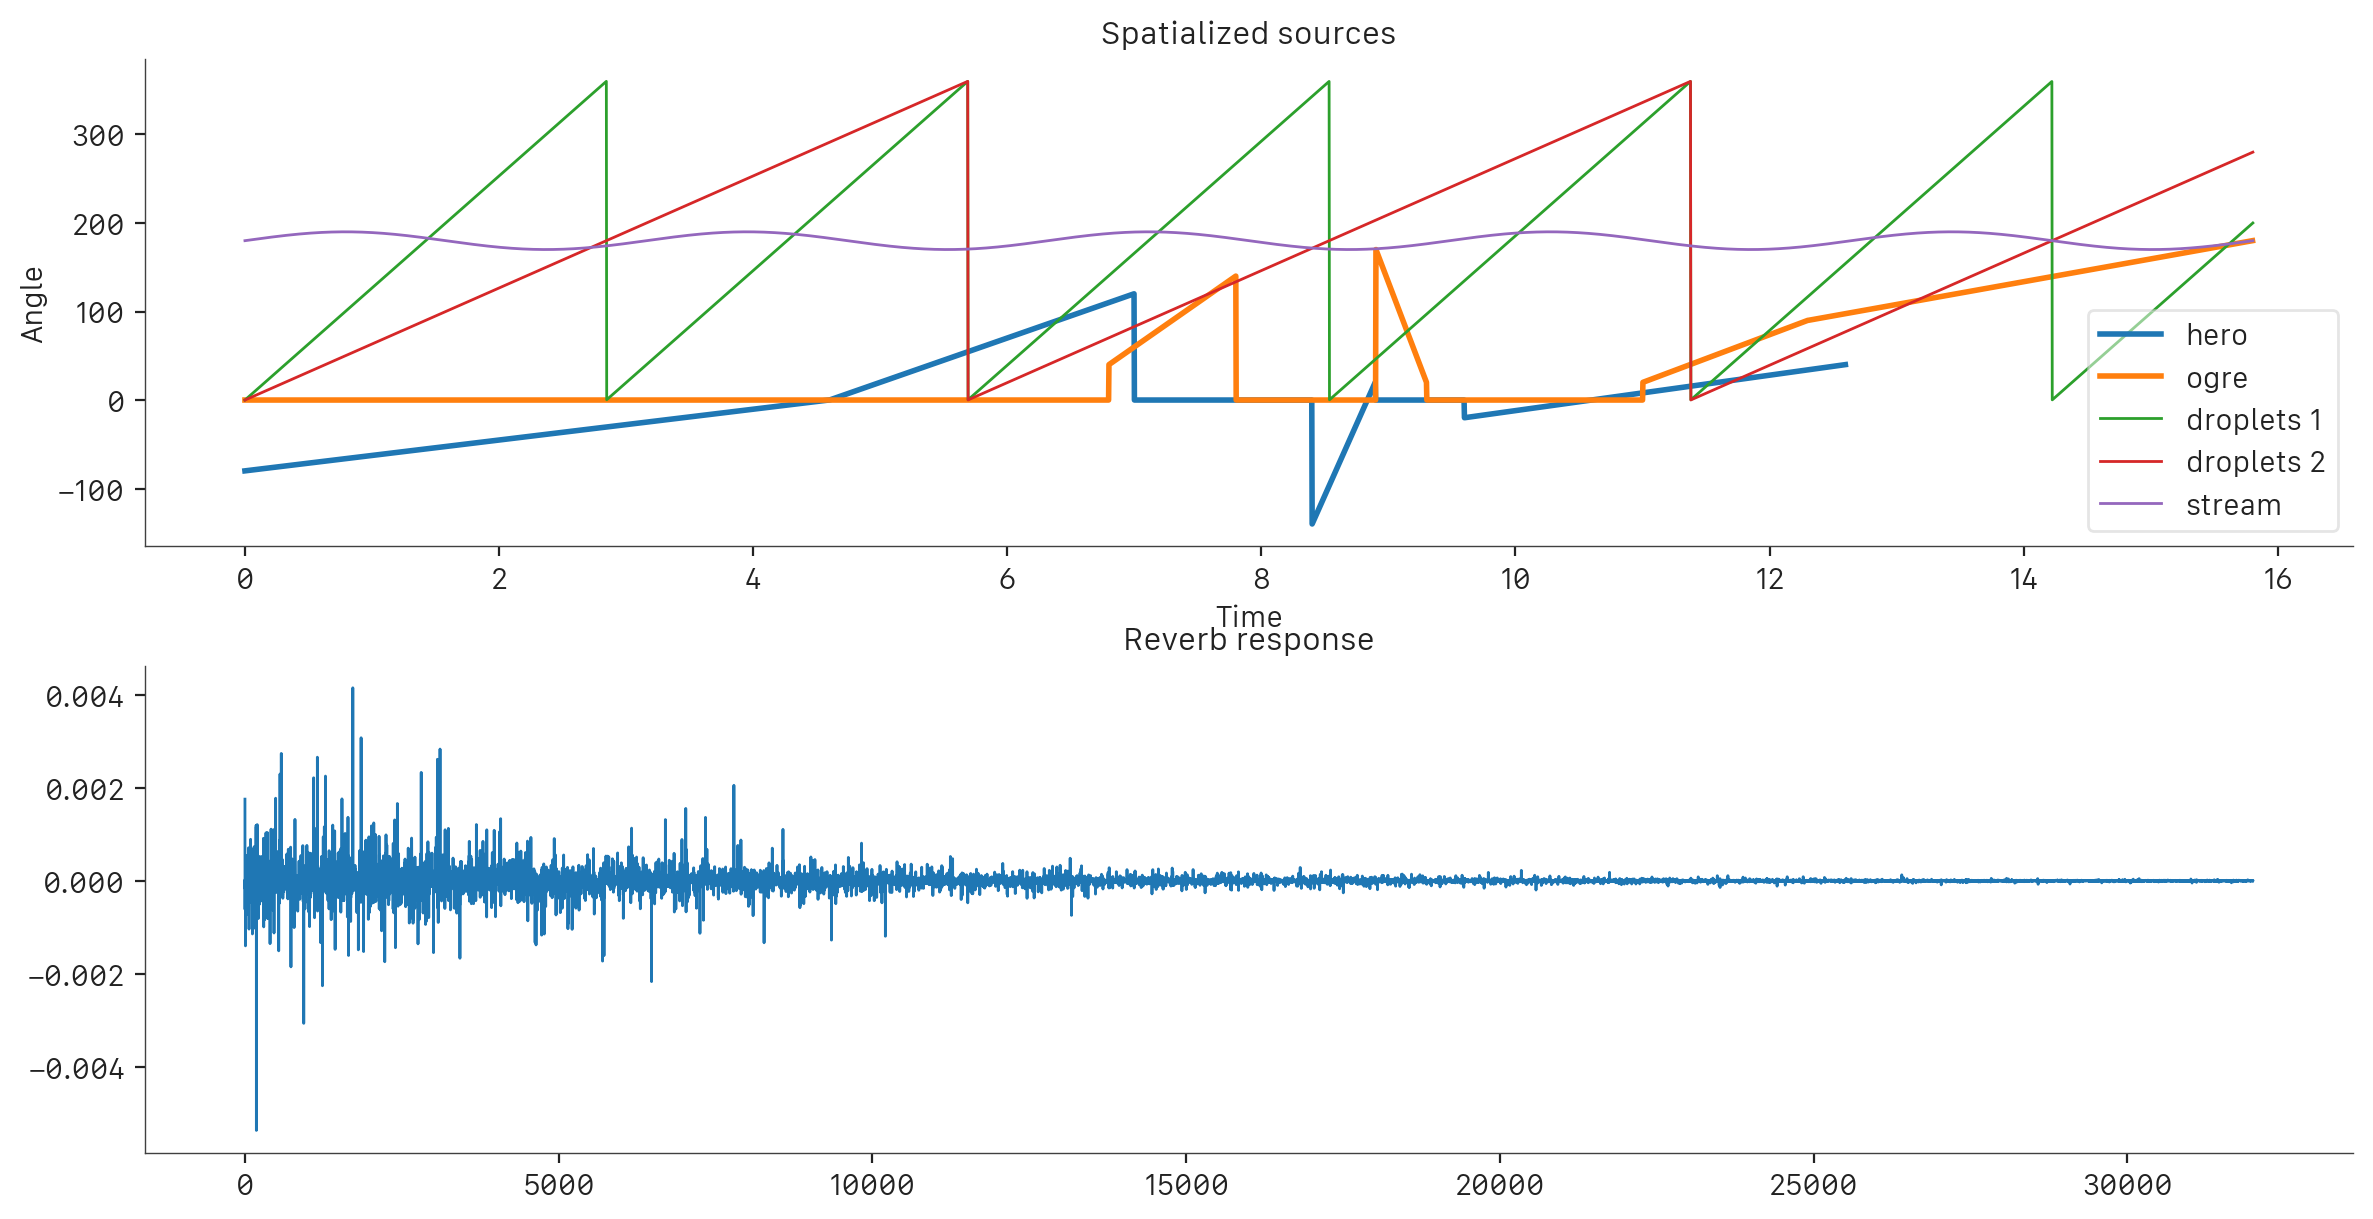

In [55]:
from numpy import hstack, logspace, sum
from numpy.random import randn

sr,s = wavreadurl( 'https://drive.google.com/uc?export=download&id=1bxQkXcGa57S3G7IRWu9urS-jCPdf5Pif')

# convenience function
def cint( i):
    return int( round( i))

# Length of processing frames
tf = sr/128

#
# Spatialize the hero sounds
#

# Make a list of locations
a = hstack((
		linspace( -80, 0, cint(4.6*tf)), 	# Steps go from -80 degrees to center
		linspace( 0, 120, cint(2.4*tf)), 	# Door creek goes from center to 120 degrees
		zeros( cint(1.4*tf)), 		        # Silence
		linspace( -140, 20, cint(.5*tf)), 	# Shotgun cocking from -140 to 20 degrees
		zeros( cint(.7*tf)), 		        # Silence
		linspace( -20, 0, cint(1*tf)), 		# Yell from -20 degrees to center
		linspace( 0, 40, cint(2*tf)) 		# Shooting from center to 40 degrees
))
subplot( 2, 1, 1)
plot( arange( len( a))*128/sr, a, lw=2, label='hero')

# Convolve with HRTFs
z1 = dynamic_hrtf( sum( s[:,[0,1,3]], 1), a)

#
# Spatialize the ogre sounds
#

# Make location index
a = hstack((
		zeros( cint(6.8*tf)), 			    # Silence
		linspace( 40, 140, cint( 1*tf)),	# Growl from 40 to 140 degrees
		zeros( cint(1.1*tf)),			    # Silence
		linspace( 170, 20, cint( .4*tf)),	# What tha? from 170 to 20 degrees
		zeros( cint(1.7*tf)),			    # Silence
        linspace( 20, 90, cint( 1.3*tf)),	# Hits from 20 to 90 degrees
		linspace( 90, 180, cint( 3.5*tf)) 	# Bye cruel world from 90 to 180 degrees
))
plot( arange( len( a))*128/sr, a, lw=2, label='ogre')

# Convolve with HRTFs
z2 = dynamic_hrtf( s[:,2], a)

#
# Spatialize first droplets
#

# Just have them twirling around 
a = linspace( 0, 2000, cint( s.shape[0]/sr*tf)-1) % 360
plot( arange( len( a))*128/sr, a, label='droplets 1')

# Convolve with HRTFs
z3 = dynamic_hrtf( s[:,4], a)


#
# Spatialize the second droplets
#

# More twirling around at a different rate
a = linspace( 0, 1000, cint( s.shape[0]/sr*tf)-1) % 360
plot( arange( len( a))*128/sr, a, label='droplets 2')

# Convolve with HRTFs
z4 = dynamic_hrtf( s[:,5], a)


#
# Spatialize the water stream
#

# Do a mild location oscillation
a = 180 + 10*sin( linspace( 0, 10*pi, cint( s.shape[0]/sr*tf)-1))
plot( arange( len( a))*128/sr, a, label='stream')
xlabel( 'Time'), ylabel( 'Angle'), title( 'Spatialized sources'), legend()
tight_layout()

# Convolve with HRTFs
z5 = dynamic_hrtf( s[:,6], a)


#
# Add some reverb
#

from scipy.signal import fftconvolve

# Make an impulse response
r = (randn(32000)**3) * logspace( 1, -1, 32000)
r = r / sum( abs( r))
subplot( 2, 1, 2), plot( r), title( 'Reverb response')

# Apply a dry-ish mix to hero sound
rz1 = z1 + .3*vstack( (fftconvolve( z1[0], r, mode='same'),fftconvolve( z1[1], r, mode='same')))

# Apply a dry-ish mix to ogre sound
rz2 = z2 + .3*vstack( (fftconvolve( z2[0], r, mode='same'),fftconvolve( z2[1], r, mode='same')))

# Apply a wetter mix to droplets and stream sound
rz3 = z3 + .5*vstack( (fftconvolve( z3[0], r, mode='same'),fftconvolve( z3[1], r, mode='same')))
rz4 = z4 + .5*vstack( (fftconvolve( z4[0], r, mode='same'),fftconvolve( z4[1], r, mode='same')))
rz5 = z5 + .5*vstack( (fftconvolve( z5[0], r, mode='same'),fftconvolve( z5[1], r, mode='same')))

#
# Get the final mix
#

z = rz1 + rz2 + 3*rz3 + 2*rz4 + 2*rz5

# Make sure to listen with headphones
sound( z, sr)